# DelibAnalysis Classification

The following script implements the random forests classifier in order to predict the Discourse Quality Index (DQI) category of online comments.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [26]:
# Functions to process labelled data

def process_labelled_data(source_csv):
    data_df = pd.read_csv(source_csv)
    indicators = ['participation', 'level_of_justification', 'content_of_justification', 'respect', 'counterarguments', 'constructive_politics']
    data_df['dqi'] = data_df[indicators].sum(axis=1)
    data_df['dqi_groups'] = data_df.dqi.map( lambda x: 0 if x <= 5 else 1 if (x > 5 and x <=10) else 2)
    data = data_df[['dqi', 'comment', 'dqi_groups','fb_comment', 'live_th', 'blog_comment']]
    return data

def comment_to_words(raw_comment):
    try:
        letters_only = re.sub("[^a-zA-Z]", " ", raw_comment)
        words = letters_only.lower().split()
        stops = set(stopwords.words("english"))
        meaningful_words = [w for w in words if not w in stops]
        return(" ".join(meaningful_words))
    except TypeError: 
        print raw_comment

def add_character_counts(data_df):
    print data_df.head()
    data_df['char_count'] = data_df['comment'].apply(lambda x: len(x))
    data_df['less_than_30_chars'] = data_df.char_count.map(lambda x: 1 if x <= 30 else 0)
    data_df['between_30_and_100_chars'] = data_df.char_count.map(lambda x: 1 if (x <= 100 and x > 30) else 0)
    data_df['between_100_and_300_chars'] = data_df.char_count.map(lambda x: 1 if (x <= 300 and x > 100) else 0)
    data_df['between_300_and_800_chars'] = data_df.char_count.map(lambda x: 1 if (x <= 800 and x > 300) else 0)
    data_df['between_800_and_1500_chars'] = data_df.char_count.map(lambda x: 1 if (x <= 1500 and x > 800) else 0)
    data_df['between_1500_and_3000_chars'] = data_df.char_count.map(lambda x: 1 if (x <=3000 and x > 1500) else 0)
    data_df['more_than_3000_chars'] = data_df.char_count.map(lambda x: 1 if x > 3000 else 0)
    features = data_df.columns[[3,4,5,6,7,8,9,10,11,12,13,14]]
    print features
    return data_df

def unlabelled_add_character_counts(data_df):
    print data_df.head()
    data_df['char_count'] = data_df['comment'].apply(lambda x: len(x))
    data_df['less_than_30_chars'] = data_df.char_count.map(lambda x: 1 if x <= 30 else 0)
    data_df['between_30_and_100_chars'] = data_df.char_count.map(lambda x: 1 if (x <= 100 and x > 30) else 0)
    data_df['between_100_and_300_chars'] = data_df.char_count.map(lambda x: 1 if (x <= 300 and x > 100) else 0)
    data_df['between_300_and_800_chars'] = data_df.char_count.map(lambda x: 1 if (x <= 800 and x > 300) else 0)
    data_df['between_800_and_1500_chars'] = data_df.char_count.map(lambda x: 1 if (x <= 1500 and x > 800) else 0)
    data_df['between_1500_and_3000_chars'] = data_df.char_count.map(lambda x: 1 if (x <=3000 and x > 1500) else 0)
    data_df['more_than_3000_chars'] = data_df.char_count.map(lambda x: 1 if x > 3000 else 0)
    features = data_df.columns[[1,2,3,4,5,6,7,8,9]]
    print features
    return data_df

In [27]:
# Upload and process labelled data

labelled_data = process_labelled_data("combined_scored.csv")
labelled_data["cleaned_comment"] = labelled_data["comment"].apply(lambda x: comment_to_words(x))
labelled_data = add_character_counts(labelled_data)

   dqi                                            comment  dqi_groups  \
0  2.0                           How about lowering taxes           0   
1  2.0                              Why the interruption?           0   
2  2.0  Make it mandatory that all apartments accept p...           0   
3  1.0                                            Resign!           0   
4  1.0                           Loser PM, please go away           0   

   fb_comment  live_th  blog_comment                        cleaned_comment  
0           1        0             0                         lowering taxes  
1           1        0             0                           interruption  
2           1        0             0  make mandatory apartments accept pets  
3           1        0             0                                 resign  
4           1        0             0                loser pm please go away  
Index([u'fb_comment', u'live_th', u'blog_comment', u'cleaned_comment',
       u'char_count', 

In [34]:
# Train classifier 

train, test = train_test_split(labelled_data, train_size = 0.8, random_state = 44)

vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, \
                             max_features = 6000)

train_data_features = vectorizer.fit_transform(train["cleaned_comment"])
train_data_features = train_data_features.toarray()

print train_data_features.shape

def append_features(input_matrix,input_feature):
    count = 0
    new_matrix = np.zeros(shape=(input_matrix.shape[0], input_matrix.shape[1]+1))
    for i in range(0, len(input_feature)):
        new_matrix[i] = np.append(input_matrix[i], input_feature[i])
    return new_matrix

add_fb = append_features(train_data_features, train["fb_comment"].as_matrix())
add_th = append_features(add_fb, train["live_th"].as_matrix())
add_blog = append_features(add_th, train["blog_comment"].as_matrix())
add_less_than_30 = append_features(add_blog, train["less_than_30_chars"].as_matrix())
add_30_100 = append_features(add_less_than_30, train["between_30_and_100_chars"].as_matrix())
add_100_300 = append_features(add_30_100, train["between_100_and_300_chars"].as_matrix())
add_300_800 = append_features(add_100_300, train["between_300_and_800_chars"].as_matrix())
add_800_1500 = append_features(add_300_800, train["between_800_and_1500_chars"].as_matrix())
add_1500_3000 = append_features(add_800_1500, train["between_1500_and_3000_chars"].as_matrix())
add_more_than_300 = append_features(add_1500_3000, train["more_than_3000_chars"].as_matrix())

print '(Number of comments, number of features)'
print add_more_than_300.shape

(576, 6000)
(Number of comments, number of features)
(576, 6010)


In [35]:
# Create the classifier
forest = RandomForestClassifier(n_jobs=4, n_estimators=30, criterion="entropy", warm_start=True, max_depth=17, bootstrap=False)
y,_ = pd.factorize(train['dqi_groups'])
forest.fit(add_more_than_300, y)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=17, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=4,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

Feature ranking:


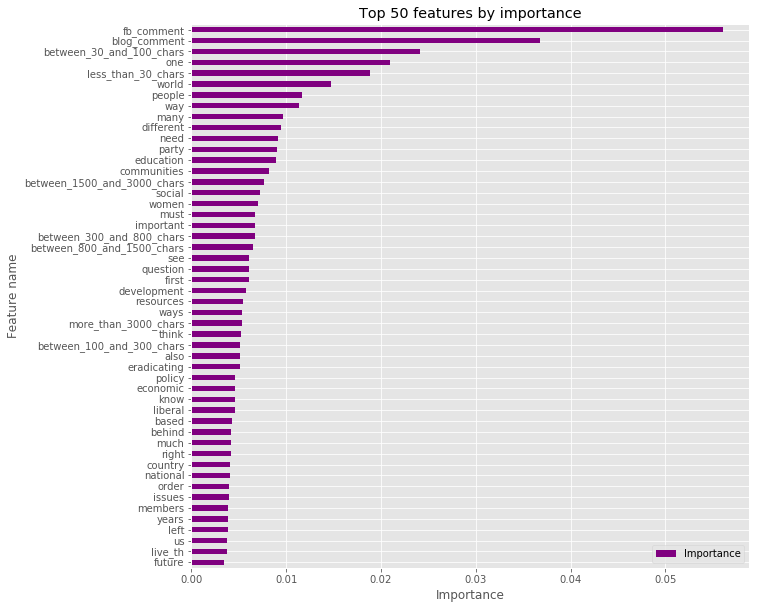

In [36]:
# View the top features used by the classifier by importance
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
vocab = vectorizer.get_feature_names()
vocab.append('fb_comment')
vocab.append('live_th')
vocab.append('blog_comment')
vocab.append('less_than_30_chars')
vocab.append('between_30_and_100_chars')
vocab.append('between_100_and_300_chars')
vocab.append('between_300_and_800_chars')
vocab.append('between_800_and_1500_chars')
vocab.append('between_1500_and_3000_chars')
vocab.append('more_than_3000_chars')

# Print the feature ranking
print("Feature ranking:")

feature_importance_df = pd.DataFrame(data=None, columns = ['Feature name', 'Importance'])
#for f in range(add_more_than_300.shape[1]):
for f in range(0,50):
    feature_importance_df.loc[f+1] = [vocab[indices[f]], importances[indices[f]]]

plt = feature_importance_df.plot(kind="barh", figsize=(10,10), color="purple")
plt.set_yticklabels(feature_importance_df["Feature name"])
plt.invert_yaxis()
plt.set_title("Top 50 features by importance")
plt.set_xlabel("Importance")
plt.set_ylabel("Feature name")


In [37]:
# Process the test data

test_data_features = vectorizer.transform(test["cleaned_comment"])
test_data_features = test_data_features.toarray()

print test_data_features.shape

test_add_fb = append_features(test_data_features, test["fb_comment"].as_matrix())
test_add_th = append_features(test_add_fb, test["live_th"].as_matrix())
test_add_blog = append_features(test_add_th, test["blog_comment"].as_matrix())
test_add_less_than_30 = append_features(test_add_blog, test["less_than_30_chars"].as_matrix())
test_add_30_100 = append_features(test_add_less_than_30, test["between_30_and_100_chars"].as_matrix())
test_add_100_300 = append_features(test_add_30_100, test["between_100_and_300_chars"].as_matrix())
test_add_300_800 = append_features(test_add_100_300, test["between_300_and_800_chars"].as_matrix())
test_add_800_1500 = append_features(test_add_300_800, test["between_800_and_1500_chars"].as_matrix())
test_add_1500_3000 = append_features(test_add_800_1500, test["between_1500_and_3000_chars"].as_matrix())
test_add_more_than_300 = append_features(test_add_1500_3000, test["more_than_3000_chars"].as_matrix())

print '(Number of comments, number of features)'
print test_add_more_than_300.shape

(144, 6000)
(Number of comments, number of features)
(144, 6010)


In [38]:
# Evaluate the classifier by predicting the score of the test group

result = forest.predict(test_add_more_than_300)

output = pd.DataFrame(data={"actual_dqi": test["dqi_groups"], "predicted_dqi": result})

# Create confusion matrix

print pd.crosstab(output['actual_dqi'], output['predicted_dqi'], rownames=['Actual'], \
                           colnames=['Predicted'])

print '\n*Classification Report:\n', classification_report(output['actual_dqi'], output['predicted_dqi']) 

Predicted   0   1
Actual           
0          77   9
1          13  42
2           0   3

*Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.90      0.88        86
          1       0.78      0.76      0.77        55
          2       0.00      0.00      0.00         3

avg / total       0.81      0.83      0.82       144



/Users/eleonoreft/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
